## Example 1.7 - Blood pressure body mass and age

In [1]:
library(ggm)
data(derived)
raw <- derived$raw
head(raw)
derived <- with(raw, data.frame(X1 = log(Sys / Dia), X2 = log(Dia), X3 = 100 * Wei / Hei, X4 = Age))
head(derived)


,Sys,Dia,Age,Hei,Wei
,<int>,<int>,<int>,<int>,<int>
1,115,80,35,163,58
2,120,80,31,162,58
3,120,80,22,170,59
4,110,70,23,164,50
5,110,70,18,179,58
6,105,60,28,167,62


,X1,X2,X3,X4
,<dbl>,<dbl>,<dbl>,<int>
1,0.3629055,4.382027,35.58282,35
2,0.4054651,4.382027,35.80247,31
3,0.4054651,4.382027,34.70588,22
4,0.4519851,4.248495,30.48780,23
5,0.4519851,4.248495,32.40223,18
6,0.5596158,4.094345,37.12575,28


Calculate the sufficient statistics

In [2]:
S <- cov(derived)
mx <- sapply(derived, function(x) mean(x))
sx <- sapply(derived, function(x) sd(x))
round(mx, 2)
round(sx, 2)
round(correlations(S), 2)


X1    X2    X3    X4 
 0.45  4.29 37.94 29.52

X1    X2    X3    X4 
 0.09  0.13  5.91 10.47

,X1,X2,X3,X4
X1,1.00,-0.57,-0.24,0.30
X2,-0.54,1.00,-0.11,0.49
X3,-0.25,0.34,1.00,0.57
X4,-0.13,0.51,0.61,1.00


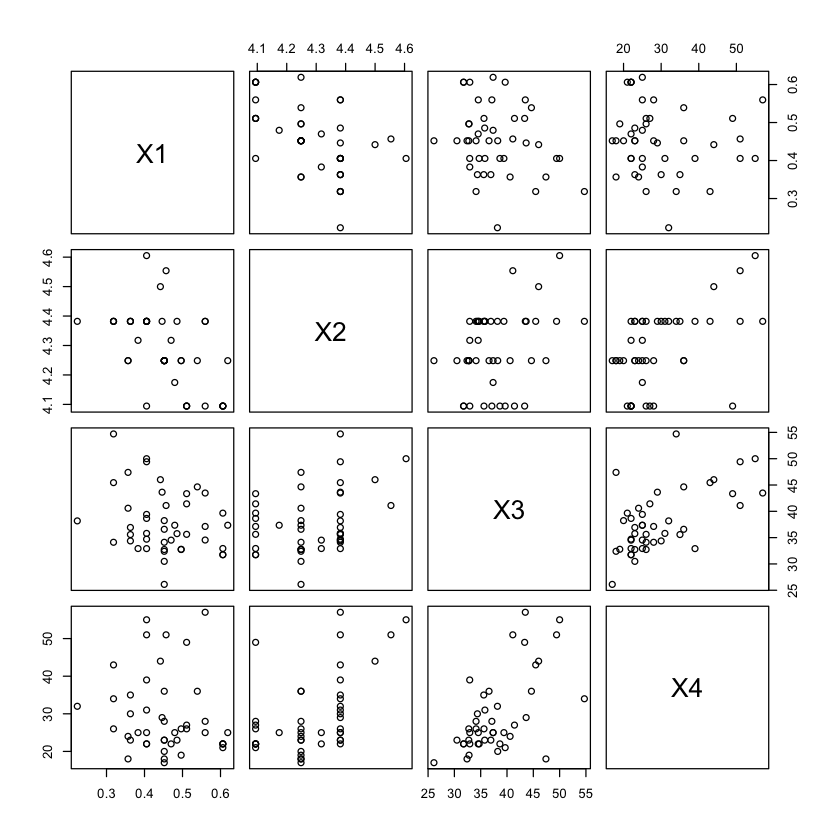

In [3]:
pairs(derived)


Fit two univariate regressions

In [4]:
round(summary(lm(X1 ~ X3 + X4, data = derived))$coef, 3)
round(summary(lm(X2 ~ X3 + X4, data = derived))$coef, 3)


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.603,0.090,6.670,0.000
X3,-0.004,0.003,-1.448,0.155
X4,0.000,0.002,0.192,0.849


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),4.076,0.116,35.085,0.000
X3,0.001,0.004,0.238,0.813
X4,0.006,0.002,2.871,0.006


Suggests removing $X_1 \leftarrow X_4$ and $X_2 \leftarrow X_3$

### Standardized regression coefficients

The standardized regression coefficients are

In [5]:
`mreg_stand` <- function(a, b, data) {
    S <- cov(data)
    D <- diag(diag(S)^(-1 / 2))
    S_ <- D %*% S %*% D
    B <- S_[a, b] %*% solve(S_[b, b])
    B
}


In [6]:
round(mreg_stand(c(1, 2), c(3, 4), derived), 3)


-0.275,0.036
0.040,0.486


**Comment** (Nanny Wermuth): The least-squares coefficients in standardized variables in the estimated regression coefficient matrix reflect the simplifying structure, while the least-squares coefficients in the unstandardized variables depend on the measurement scales, and hence their size may not be directly compared.

### Fit the seemingly unrelated regression model

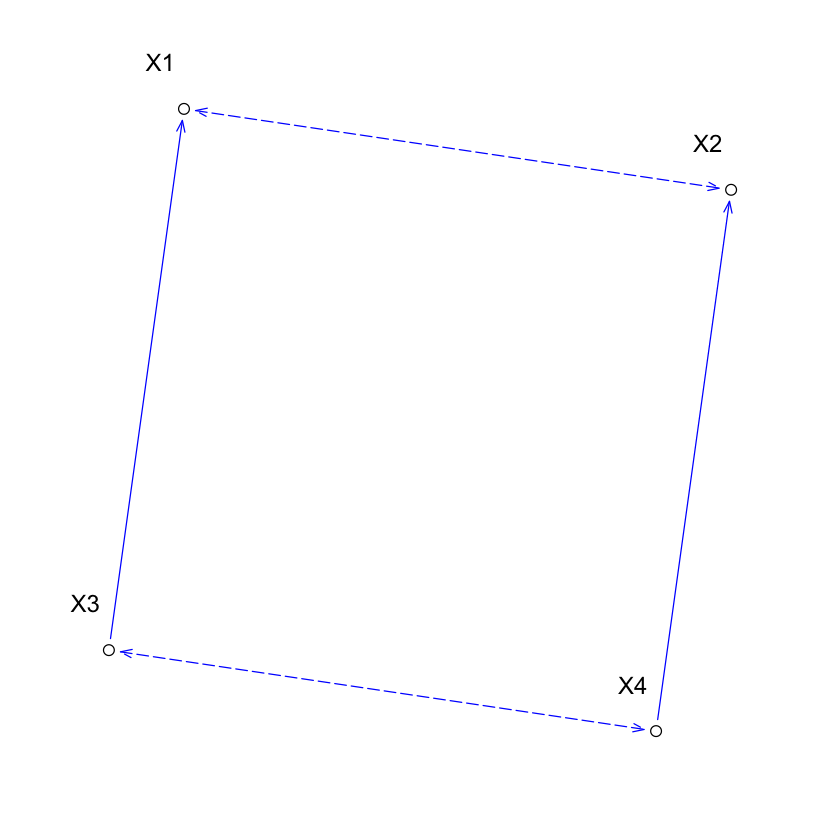

In [7]:
R <- makeMG(bg = UG(~ X1 * X2 + X3 * X4), dg = DAG(X1 ~ X3, X2 ~ X4))
drawGraph(R)


### Using package **sem**

First fit the saturated model

In [8]:
library(sem)

sat <- specifyModel(text = "
X3 -> X1,  b13, NA
X4 -> X1,  b14, NA
X3 -> X2,  b23, NA
X4 -> X2,  b24, NA
X1 <-> X2, s12, NA
X1 <-> X1, s11, NA
X2 <-> X2, s22, NA
X3 <-> X3, s33, NA
X4 <-> X4, s44, NA
X3 <-> X4, s34, NA
")

m_sat <- sem(sat, S, N = 44)
options(scipen = 5)
print(summary(m_sat), digits = 2)


NOTE: it is generally simpler to use specifyEquations() or cfa()
      see ?specifyEquations




 Model Chisquare =  -9.5e-15   Df =  0 Pr(>Chisq) = NA
 AIC =  20
 BIC =  -9.5e-15

 Normalized Residuals
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.0e+00 0.0e+00 0.0e+00 2.0e-16 3.3e-16 9.5e-16 

 R-square for Endogenous Variables
   X1    X2 
0.065 0.261 

 Parameter Estimates
    Estimate  Std Error z value Pr(>|z|)            
b13  -0.00420  0.0028   -1.48   0.1382197 X1 <--- X3
b14   0.00031  0.0016    0.20   0.8444373 X1 <--- X4
b23   0.00089  0.0036    0.24   0.8072188 X2 <--- X3
b24   0.00604  0.0021    2.94   0.0032768 X2 <--- X4
s12  -0.00553  0.0017   -3.23   0.0012363 X2 <--> X1
s11   0.00760  0.0016    4.64   0.0000035 X1 <--> X1
s22   0.01254  0.0027    4.64   0.0000035 X2 <--> X2
s33  34.89473  7.5256    4.64   0.0000035 X3 <--> X3
s44 109.69715 23.6579    4.64   0.0000035 X4 <--> X4
s34  37.63139 11.0432    3.41   0.0006553 X4 <--> X3

 Iterations =  0 


Then fit the reduce model

In [9]:
library("sem")
sur <- specifyModel(text = "
X3 -> X1,  b13, NA
X4 -> X2,  b24, NA
X1 <-> X2, s12, NA
X1 <-> X1, s11, NA
X2 <-> X2, s22, NA
X3 <-> X3, s33, NA
X4 <-> X4, s44, NA
X3 <-> X4, s34, NA
")

m_sur <- sem(sur, S, N = 44)
print(summary(m_sur), digits = 2)


NOTE: it is generally simpler to use specifyEquations() or cfa()
      see ?specifyEquations




 Model Chisquare =  0.074   Df =  2 Pr(>Chisq) = 0.96
 AIC =  16
 BIC =  -7.5

 Normalized Residuals
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -0.085  -0.038   0.000   0.014   0.047   0.130 

 R-square for Endogenous Variables
   X1    X2 
0.058 0.266 

 Parameter Estimates
    Estimate Std Error z value Pr(>|z|)            
b13  -0.0037  0.0020   -1.9    0.0639009 X1 <--- X3
b24   0.0064  0.0014    4.5    0.0000069 X2 <--- X4
s12  -0.0055  0.0017   -3.2    0.0012271 X2 <--> X1
s11   0.0076  0.0016    4.6    0.0000035 X1 <--> X1
s22   0.0126  0.0027    4.6    0.0000035 X2 <--> X2
s33  34.8947  7.5256    4.6    0.0000035 X3 <--> X3
s44 109.6971 23.6579    4.6    0.0000035 X4 <--> X4
s34  37.6314 11.0432    3.4    0.0006553 X4 <--> X3

 Iterations =  10 
